# <a href='https://www.kaggle.com/c/titanic/overview'>Titanic Survival</a>
## Kaggle machine learning competition
### Supervised learning for binary classification

#### Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Here, we complete the analysis of what sorts of people were likely to survive. In particular, use machine learning to predict which passengers survived the tragedy.

#### Variable Notes

__name__: Name of Passenger in the following format:
-   Males / Unmarried Females / Minors = Surname, Title First_name Middle_name 
-   Married Females = Husband_surnmae, Title Husband_first_name Husband_middle_name (Maiden_name)

__pclass__: A proxy for socio-economic status (SES)
-   1st = Upper
-   2nd = Middle
-   3rd = Lower

__age__: 
    Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

__sibsp__: 
    The dataset defines family relations in this way... <br/>
    Sibling = brother, sister, stepbrother, stepsister <br/>
    Spouse = husband, wife (mistresses and fiancés were ignored)

__parch__: 
    The dataset defines family relations in this way...
    Parent = mother, father <br/>
    Child = daughter, son, stepdaughter, stepson <br/>
    Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import utility as util
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import HTML
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format='retina'
%matplotlib inline

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    Credits to epmoyer
    link https://github.com/epmoyer/ipy_table/issues/24
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

## Importing titanic data

In [2]:
'''For future reference:
Making a list of missing value types '''
# missing_values = ["n/a", "na", "--"]
# df = pd.read_csv("property data.csv", na_values = missing_values)

### The entire process above can be streamlined to use pandas read_csv command
train, test, result_example = pd.read_csv('data/train.csv', index_col=0), pd.read_csv('data/test.csv', index_col=0), pd.read_csv('data/gender_submission.csv', index_col=0)
### Concatenate train and test dataset
complete_dataset = pd.concat(objs=[train.drop(columns=['Survived']), test] , axis=0)

## Visualizing the dataset
Train dataset and the result example dataset

In [3]:
multi_table([train.head(), result_example.head()])

Test dataset

In [4]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Data types
print(f"train_data.dtypes\n{train.dtypes},\n\n test_data.dtypes\n{test.dtypes},\n\n result_data_example.dtypes\n{result_example.dtypes}")

train_data.dtypes
Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object,

 test_data.dtypes
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object,

 result_data_example.dtypes
Survived    int64
dtype: object


## Checking for NaN values and dealing with them
Kernel Density Plots for numerical data. NaN values have been replaced with the value -1000

__We can also see that `Age` has a huge presence of NaN values given the hill around the placeholder value -1000__

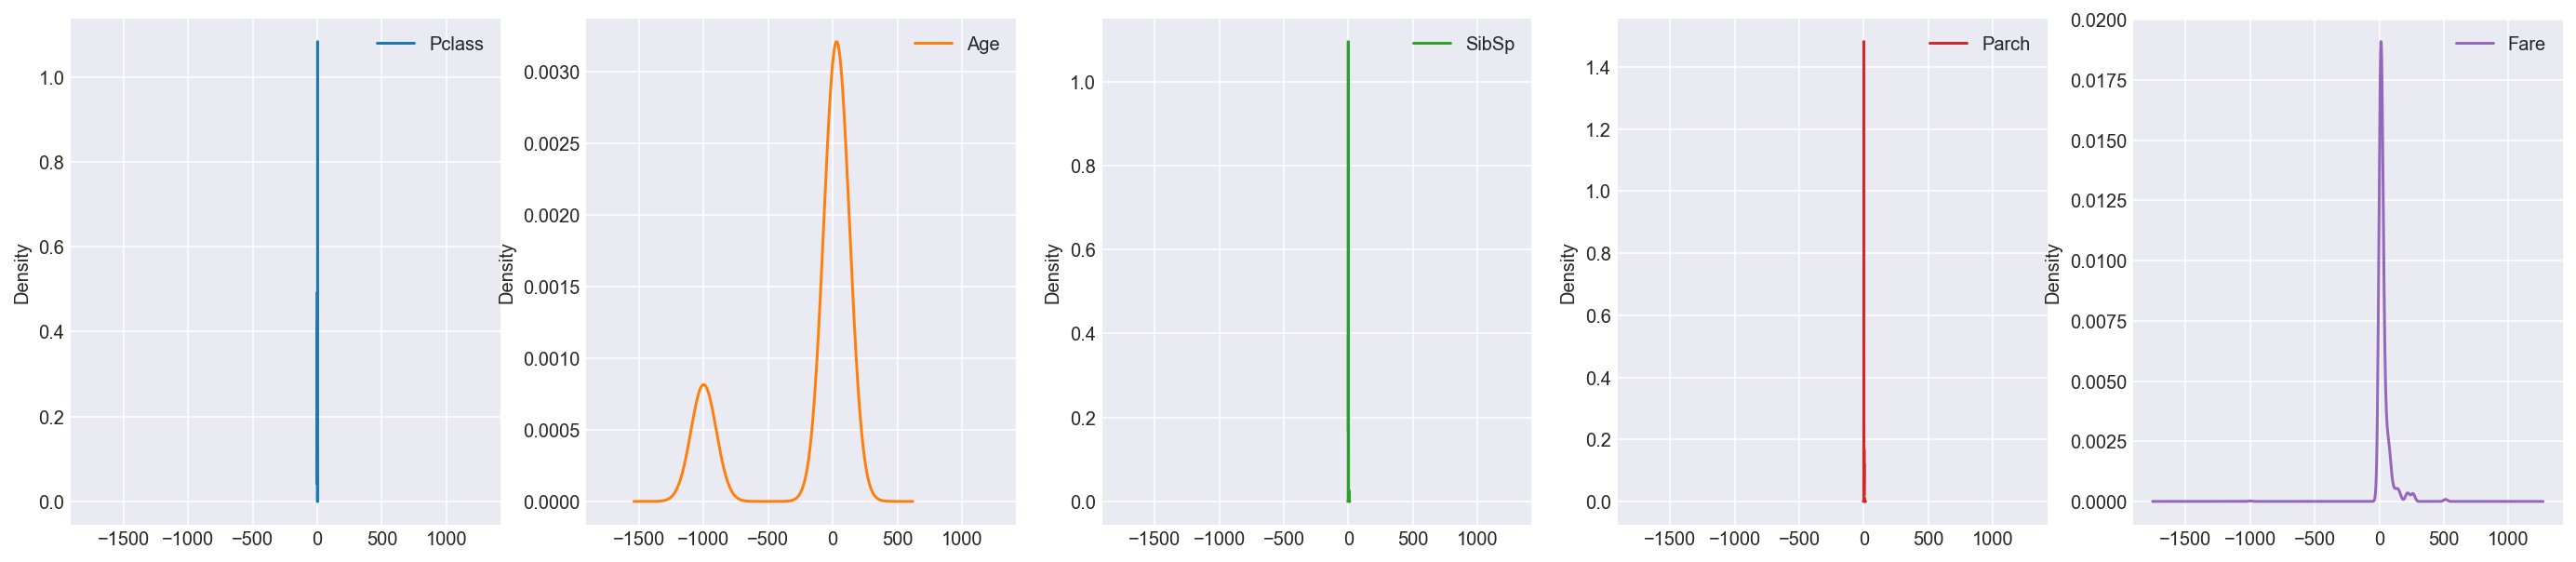

In [6]:
complete_dataset_fillna = complete_dataset.fillna(-1000)
complete_dataset_fillna.plot(kind='kde',subplots=True, layout=(1,5), figsize=(24,5))
plt.show()

### Looking at the percentage of missing data for each column.
i.e. We will be dropping columns that have less than 5% of missing values

In [7]:
nan_total = complete_dataset.isnull().sum().sort_values(ascending=False)
nan_percent = ((complete_dataset.isnull().sum() / complete_dataset.isnull().count())*100).sort_values(ascending=False)
print('Percent of NULL values in the given columns\n', nan_percent.head(), end='\n\nInformation on the complete dataset\n')
print(complete_dataset.info(), '\n\nNumber of Unique values in each column\n', complete_dataset.nunique() ) # Get information on the presence of NaN values

Percent of NULL values in the given columns
 Cabin       77.463713
Age         20.091673
Embarked     0.152788
Fare         0.076394
Ticket       0.000000
dtype: float64

Information on the complete dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB
None 

Number of Unique values in each column
 Pclass         3
Name        1307
Sex            2
Age           98
SibSp          7
Parch          8
Ticket       929
Fare         281
Cabin        186
Embarked       3
dtype: int64


Drop rows that have NaN values for the `Fare`and `Embarked` column as these columns only have 0.076% and 0.153% of NaN values which can be cast out.
In this case, only 3 observations out of 1309 will be dropped.<br/>
Now we only have to worry about the missing values for `Age` and `Cabin` columns.

We drop the column `Cabin` as it is missing 77% of its values and any imputation methods or attribute generation methods might not be effective.

In [8]:
### Drop rows for the train dataset
train.dropna(subset=['Fare', 'Embarked'], inplace=True)
### We will not drop any rows for the test dataset as we want to make a survival prediction for all rows
# test.dropna(subset=['Fare', 'Embarked'], inplace=True)

### We could drop the Cabin columnnow, but we will create another boolean column stating whether the passenger had a cabin
# train.drop(columns=['Cabin'], inplace=True), test.drop(columns=['Cabin'], inplace=True)

complete_dataset = pd.concat(objs=[train.drop(columns=['Survived']), test], axis=0)
complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 1 to 1309
Data columns (total 10 columns):
Pclass      1307 non-null int64
Name        1307 non-null object
Sex         1307 non-null object
Age         1044 non-null float64
SibSp       1307 non-null int64
Parch       1307 non-null int64
Ticket      1307 non-null object
Fare        1306 non-null float64
Cabin       293 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 112.3+ KB


Since 77.46% of the values for the feature `Cabin` is missing, we will be completely dropping that feature for training our model

## Statistical analysis of the dataset

Complete Dataset Statistical description and The Correlation matrix between the numerical features respectively


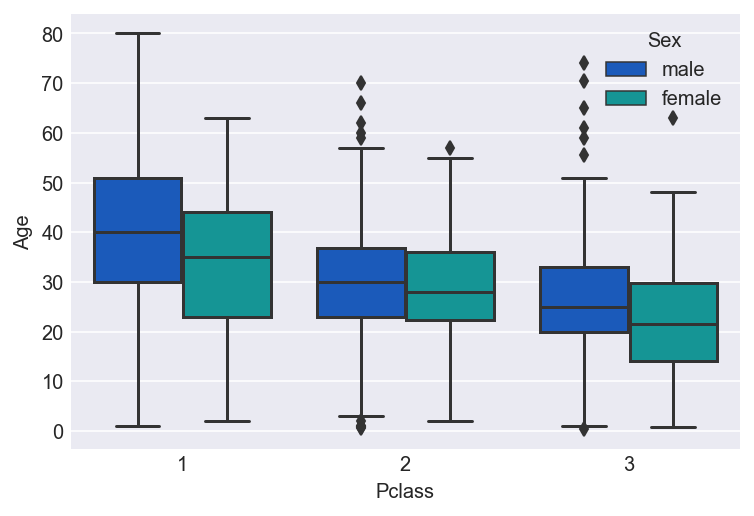

In [9]:
sns.boxplot(x='Pclass', y='Age', hue = 'Sex', data=train, palette='winter')
described_dataset = complete_dataset.describe().drop(columns='Pclass')
corr_train = train.corr().style.background_gradient(cmap='coolwarm')
print("Complete Dataset Statistical description and The Correlation matrix between the numerical features respectively")
multi_table([described_dataset, corr_train])

Since we see that the correlation between the variable we will predict, `Survived` and `age` is -0.08, we can use imputation methods to fill the missing values for the `age` column. 

Specifically, we replace the missing value of the age with a random value between one standard deviation of the mean value of the age of the matching `Sex` and `Pclass` columns.

In [10]:
complete_dataset_dropna = complete_dataset.dropna()
means = complete_dataset_dropna.groupby(['Pclass', 'Sex'])['Age'].mean()
stds = complete_dataset_dropna.groupby(['Pclass', 'Sex'])['Age'].std()
print("Mean age of each Pclass subdivided by Sex and Standard Deviation of each Pclass subdivded by Sex")
multi_table([pd.DataFrame(means), pd.DataFrame(stds) ])

Mean age of each Pclass subdivided by Sex and Standard Deviation of each Pclass subdivded by Sex


__We can observe that a higher proportion of females survived for any given Passenger Class__

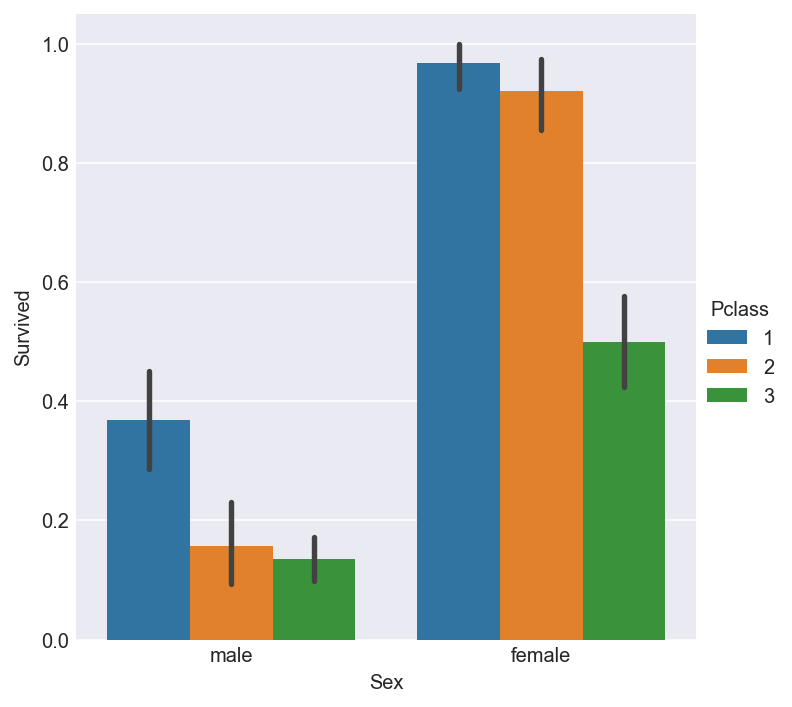

In [11]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=train);

__More Females survived compared to males__

Text(0, 0.5, 'Number survived')

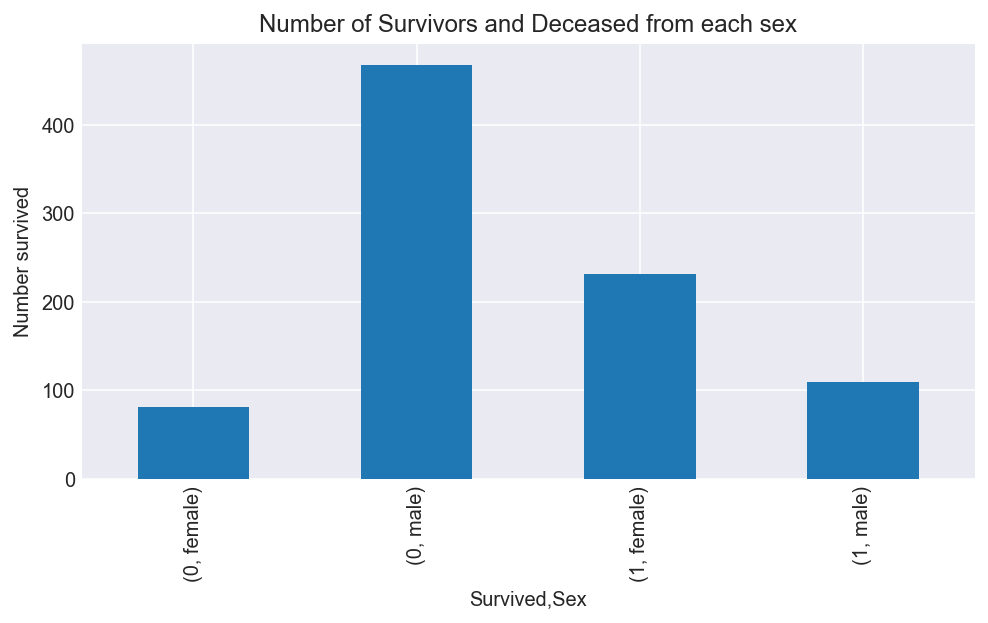

In [12]:
survival_by_sex =  train.groupby(['Survived', 'Sex']).size()
ax = survival_by_sex.plot.bar(figsize=(8,4), title='Number of Survivors and Deceased from each sex')
ax.set_ylabel('Number survived')

__Looking at average Fare for males and females in different classes, females paid more for 1st Class__

Text(0, 0.5, 'Average Fare')

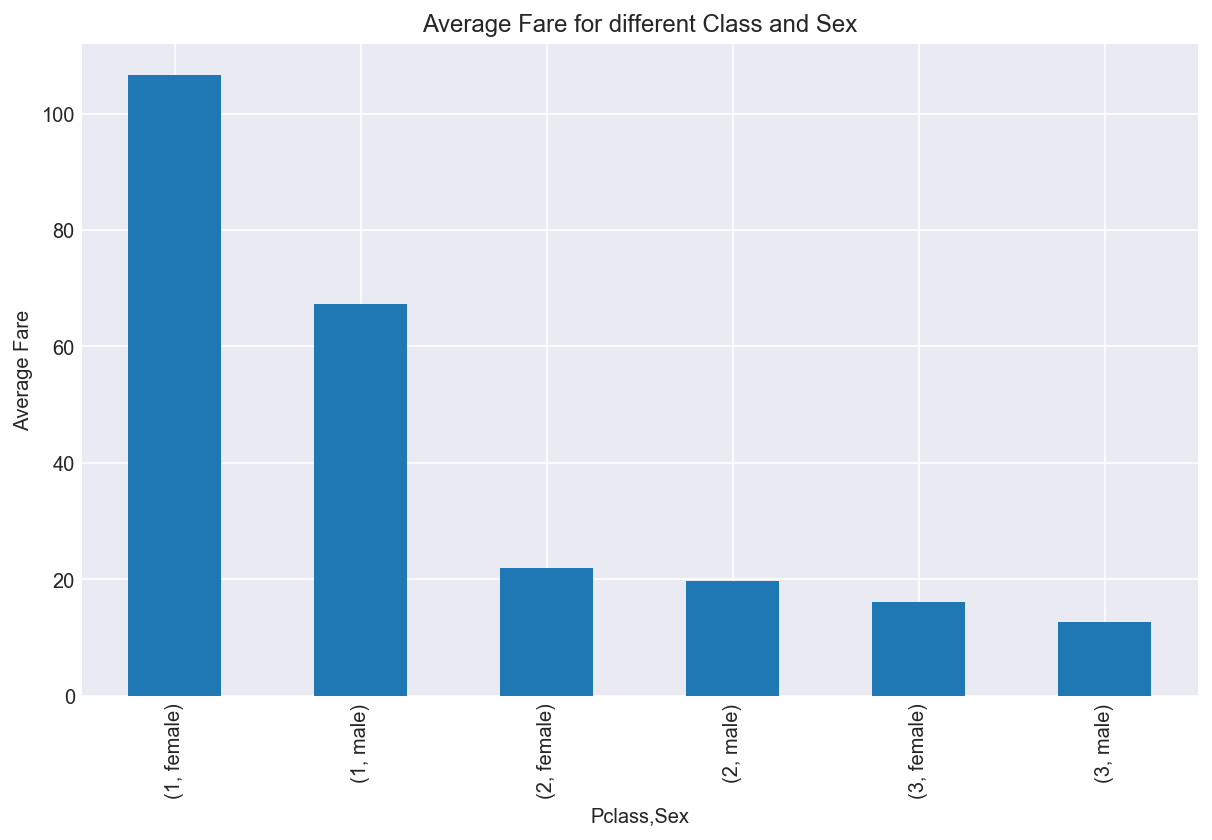

In [13]:
fare_by_class_sex = train.groupby(['Pclass', 'Sex'])['Fare'].mean()
ax = fare_by_class_sex.plot(kind='bar', figsize=[10,6], title='Average Fare for different Class and Sex')
ax.set_ylabel('Average Fare')

## Training our custom logistic regression model with sklearn pre-processing

In [14]:
multi_table([train.head(), test.head()])

### Engineering new features and removing features that will not be used
-   We fill the NaN values with a random value within one std dev from the mean from the respective pClass and Sex.
-   We convert the categorical variables (`Sex`, `Embarked`) into discrete variable classes: For feature `Sex` with 0 for males and 1 for females. For feature `Embarked`, 0 for S, 1 for C and 2 for Q.

In [15]:
# Replace the NaN age values with random values 1 std deviation of the mean
complete_dataset['Age'] = complete_dataset.groupby(['Pclass', 'Sex']).Age.transform(
    lambda col: col.replace(np.nan, np.random.randint(col.mean()-col.std(), col.mean()+col.std())))
# For the one missing fare value, use the median instead of the mean # NOTE: Might not be the best way to handle this missing value for Fare
complete_dataset['Fare'] = complete_dataset.groupby(['Pclass', 'Sex']).Fare.transform(
    lambda col: col.replace(np.nan, np.random.randint(col.median()-col.std(), col.median()+col.std())))

# Assigning the train and test datasets from the complete_dataset separately
train = pd.concat( objs=[complete_dataset.iloc[:train.shape[0]][:], train["Survived"]], axis=1 )
test = complete_dataset.iloc[train.shape[0]:][:]

def prepare_for_regr(df, test_set=False, add_bias=True):
    '''For train and test dataset 
    IMPORTANT: the train'''
    df = pd.DataFrame(df)
    
    df["Cabin"] = df["Cabin"].fillna("X")
    df["Deck"] = df["Cabin"].apply(lambda x: str(x)[0])                              # Assign first letter of Cabin for the Deck name i.e. for D120, assign D
    df["Deck"] = df["Deck"].map(\
        {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'X':8}).astype(int) # Convert Deck to numerical variables

    df["Title"] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)                # Select the Titles from the names using regular expression
#     print("Different Titles and their Counts \n", pd.DataFrame(df["Title"].value_counts() ), end='\n\n')
    df["Title"] = df["Title"].replace("Ms", "Miss")
    df["Title"] = df["Title"].replace("Mme", "Miss")
    df["Title"] = df["Title"].replace("Mlle", "Miss")
    df["Title"] = df["Title"].replace( \
        ["Dr", "Rev", "Col", "Major", "Sir", "Lady", "Capt", "Don", "Jonkheer", "Dona", "Countess"], "Special")

    df["Title"] = df["Title"].map({"Mr":0, "Mrs":1, "Master":2, "Miss":3, "Special":4}).astype(int) # Convert titles to numerical variables
#     print("Titles and their counts after combining the similar and rare ones\n", pd.DataFrame(df["Title"].value_counts()), pd.DataFrame(df['Deck'].value_counts()))

    # Convert categorical variables to discrete variables
    df["Sex"] = df["Sex"].map({'male':0, 'female':1}).astype(int)
    df["Port"] = df["Embarked"].map({'S':0, 'C':1, 'Q':2}).astype(int)
    df["hasCabin"] = df["Cabin"].apply(lambda x: 0 if x=="X" else 1 ).astype(int)
    
    if add_bias: # The x0 term
        bias = pd.DataFrame(df['Age']*0==0).astype(int).rename(columns={'Age':'bias'}) # The x0 parameter is always 1
        df = pd.concat(objs=[bias, df], axis=1)
    
    # Drop columns that will not be used
    df.drop(columns=['Embarked', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    
    df = df.reset_index()
    if test_set==False:
        df.drop(columns=['PassengerId'], inplace=True)
        df_Survived = df.pop('Survived')
        df = pd.concat(objs=[df, df_Survived], axis=1)
    
    # Normalize the Fare and Age columns
    df['Fare'] = (df['Fare'] - df['Fare'].mean()) / df['Fare'].std() 
    df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
    
    return pd.DataFrame(df)

test_numerical = prepare_for_regr(test, test_set=True)
train_numerical = prepare_for_regr(train)
multi_table([train_numerical.head(), test_numerical.head()])

,bias,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Title,Port,hasCabin,Survived
0,1,3,0,-0.447515,1,0,-0.499958,8,0,0,0,0
1,1,1,1,0.706866,1,0,0.788503,2,1,1,1,1
2,1,3,1,-0.158920,0,0,-0.486376,8,3,0,0,1
3,1,1,1,0.490420,1,0,0.422623,2,1,0,1,1
4,1,3,0,0.490420,0,0,-0.483861,8,0,0,0,0
,PassengerId,bias,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Title,Port,hasCabin
0,892,1,3,0,0.446621,0,0,-0.496535,8,0,2,0
1,893,1,3,1,1.365178,1,0,-0.511380,8,1,0,0
2,894,1,2,0,2.467447,0,0,-0.463265,8,0,2,0
3,895,1,3,0,-0.104513,0,0,-0.481616,8,0,0,0


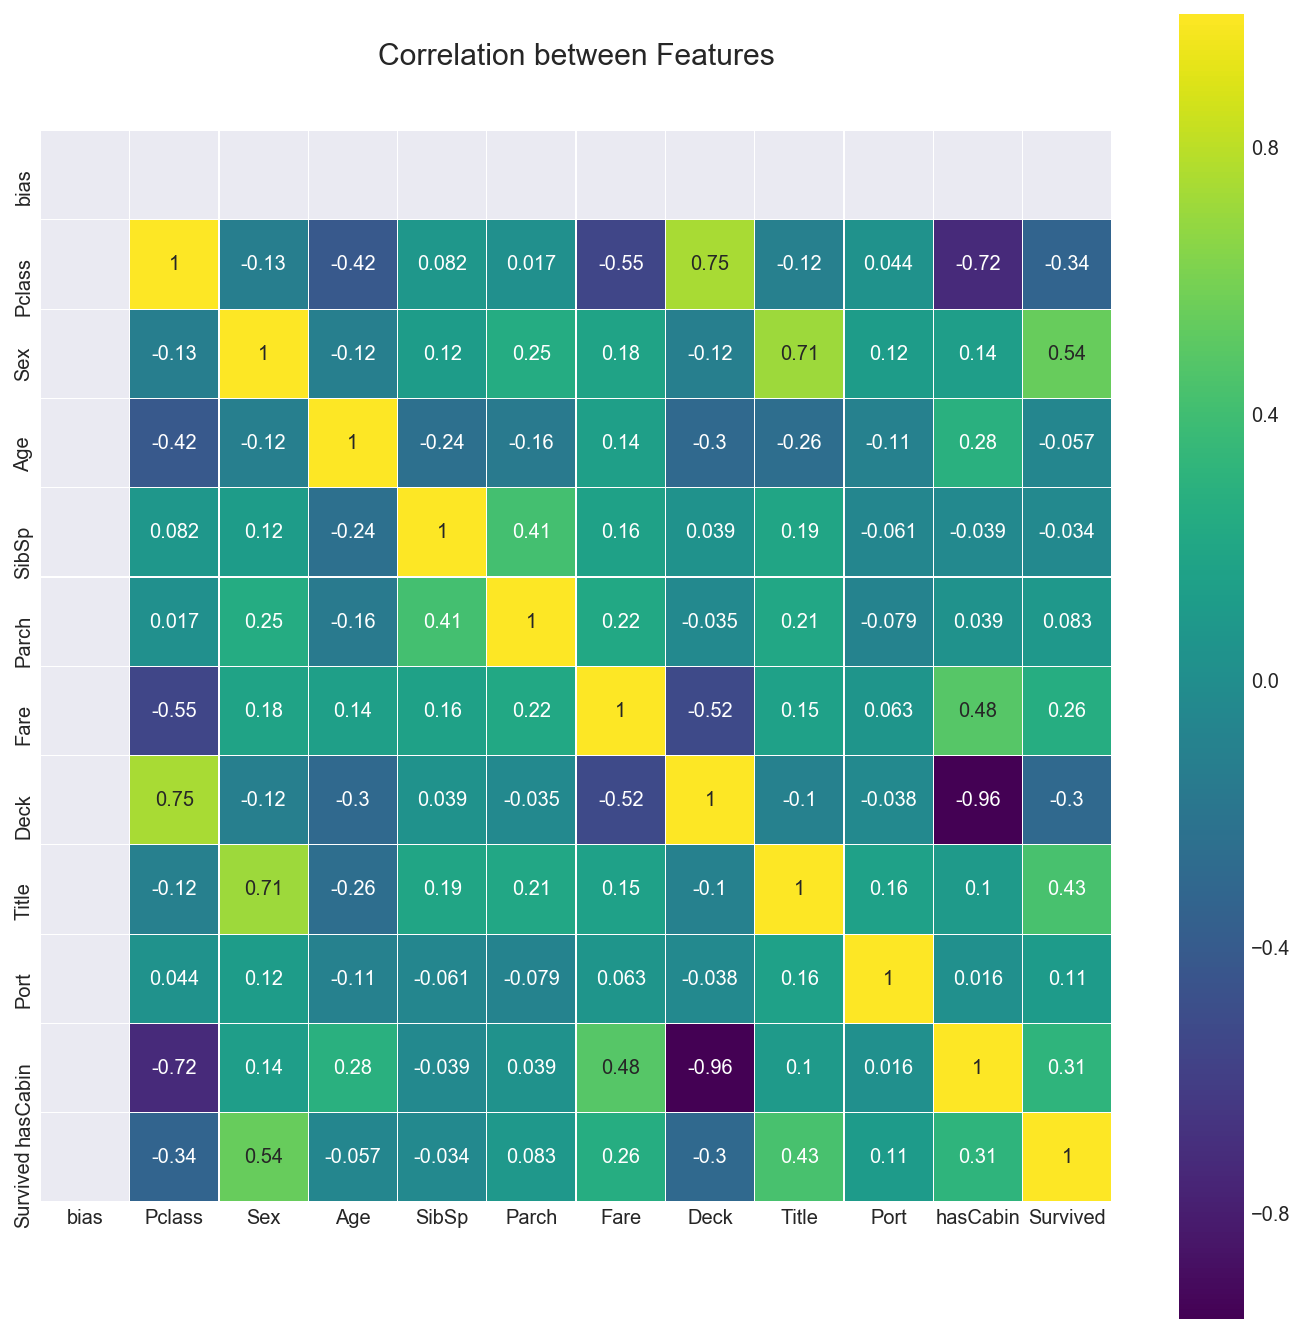

In [16]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation between Features', y=1.05, size = 15)
sns.heatmap((train_numerical).corr(),
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)

In [17]:
# We drop the hasCabin and Port(Embarked) Feature
# hasCabin has a high correlation between Deck, so hasCabin can be removed as Deck gives a more detailed level of information
# It is not clear how the port of embarkment would affect survivability so it is dropped as well
train_numerical.drop(columns=["hasCabin", "Port"], inplace=True)
test_numerical.drop(columns=["hasCabin", "Port"], inplace=True)

# Create an X_train and y_train dataset for logistic regression
# X_train is created by excluding the last Survived column and y_train is created by just using the last column
try:
    X_train, y_train = train_numerical.iloc[:,:-1].to_numpy(), train_numerical.iloc[:,-1].to_numpy()
except:
    X_train, y_train = train_numerical.iloc[:,:-1].values, train_numerical.iloc[:,-1].values
y_train = y_train.reshape([y_train.shape[0], 1])

# All NaN values have been removed from the train and test dataset
print(train.isnull().sum(), test.isnull().sum(), sep='\n')

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
Survived    0
Deck        0
Title       0
Port        0
hasCabin    0
dtype: int64
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
Deck        0
Title       0
Port        0
hasCabin    0
dtype: int64


In [18]:
#Shape of the X_features and y_target matrices
X_train.shape, y_train.shape

((889, 9), (889, 1))

In [19]:
class Logistic_regr_linear:
    def __init__(self, X_train_data, epochs, alpha, lambda_reg):
        self.loss = []
        self.epochs = epochs
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        self.theta_vector = np.zeros(X_train_data.shape[1]).reshape(X_train_data.shape[1], 1)
    
    def train(self, X_train, y_train):
        m = X_train.shape[0]
        for epoch in range(self.epochs):
            self.theta_vector -= ((self.alpha/m)*( \
                (np.transpose(X_train)).dot(util.y_pred(X_train, self.theta_vector) - y_train) \
                + (self.lambda_reg*((np.transpose(self.theta_vector)).dot(self.theta_vector)))  ))
            self.loss.append(util.logistic_loss(X_train, y_train, self.theta_vector) + \
                                                   ((self.lambda_reg/(2*m))*((np.transpose(self.theta_vector[1:])).dot(self.theta_vector[1:]))))

Parameterx for the model = [[ 0.98815598 -0.94670009  2.22773999 -0.49867045 -0.38408052 -0.09003959
   0.12396971 -0.03016875  0.16125009]], 
loss = 0.4481170006714919, 
accuracy = 0.8031496062992126


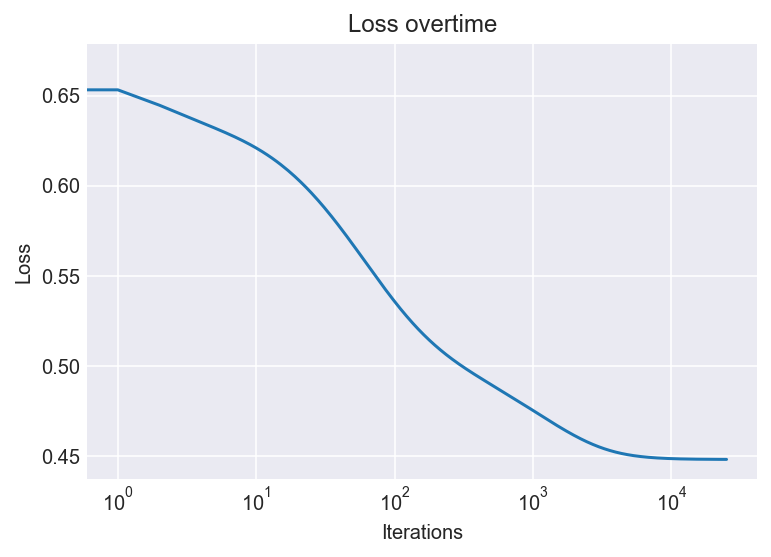

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)
l1 = Logistic_regr_linear(X_train, 25000, 0.019, 0.99)
l1.train(X_train, y_train)
util.plot_loss_curve(l1.loss, l1.epochs, log_mode=True)       # plot loss curve
util.print_accuracy_best_git_parameters(X_train, y_train, l1) # print final loss and accuracy

### Looking at what our test df looks like and what our final submission df should look like

In [21]:
multi_table([test_numerical.head(), result_example.head()])

In [22]:
def generate_predicted_csv_submission(logistic_model, test_numerical, X_test):
    '''X_test must be a numpy array and must not have the PassengerId column '''
    pred = util.y_pred(X_test, logistic_model.theta_vector)
    predicted_labels = [1 if x >= .5 else 0 for x in pred]
    
    y_test = pd.DataFrame({'PassengerId':test_numerical['PassengerId'],'Survived':predicted_labels}) # Combine the predicted values for the Survived column with the PassengerId's
    y_test = y_test.set_index('PassengerId')
    y_test.to_csv("submissions/submission_custom_logistic_regr.csv", encoding='utf-8')

In [23]:
def generate_X_test(test_numerical):
    try:
        x = test_numerical.to_numpy()
    except:
        x = test_numerical.values
    return x[:,1:]
    
generate_predicted_csv_submission(l1, test_numerical, generate_X_test(test_numerical))

## Accuracy score of model based just on linear logistic model
<img src='img/submission01.png' />

## Using sklearn's Logistic Regression function yields similar accuracy on Kaggle

In [24]:
# importing some useful sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale

# X_train = X_train[:,1:] # removing the x0 column that is the bias since we will use sklearn's 

In [25]:
# Generating new polynomial features degree=2 for features (a, b, c) generates (1, a, b, c, ab, ac, bc, a^2, b^2, c^2) or no.of feat + degree choose no. of feat
# poly = PolynomialFeatures(degree=3, include_bias=True)
# X_train = poly.fit_transform(X_train)

In [26]:
X, y = X_train, y_train.ravel()
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=5000,\
                         multi_class='ovr').fit(X, y)

predicted_labels = clf.predict(generate_X_test(test_numerical))
y_test = pd.DataFrame({'PassengerId':test_numerical['PassengerId'],'Survived':predicted_labels}) # Combine the predicted values for the Survived column with the PassengerId's
y_test = y_test.set_index('PassengerId')
y_test.to_csv("submissions/submission_sklearn_logistic_regr.csv", encoding='utf-8')
clf.score(X, y)

0.7952755905511811

## Now we use a Random Forests Classifier for the classification task

In [27]:
clf_rfc = RandomForestClassifier(n_estimators=50, bootstrap=False)
clf_rfc.fit(X, y)

predicted_labels = clf_rfc.predict(generate_X_test(test_numerical))
y_test = pd.DataFrame({'PassengerId':test_numerical['PassengerId'],'Survived':predicted_labels}) # Combine the predicted values for the Survived column with the PassengerId's
y_test = y_test.set_index('PassengerId')
y_test.to_csv("submissions/submission_sklearn_rfc.csv", encoding='utf-8')
clf_rfc.score(X, y)

0.9876265466816648